In [1]:
import sys
sys.path.append('..')

from data.tile_stitcher import stitch_predictions


In [2]:
# ckpt = '2410/Hagen-joint_indi-l1/36'
# ckpt = '2502/Hagen-joint_indi-l1/57'
# ckpt  = '2412/HT_LIF-joint_indi-l1/8'
# ckpt = '2501/COSEM_jrc-hela-joint_indi-l1/32'
# ckpt = '2502/COSEM_jrc-hela-joint_indi-l1/13'
# ckpt = '2502/HT_LIF24-joint_indi-l1/60'
ckpt = '2502/COSEM_jrc-hela-joint_indi-l1/33'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_epochs_normalization = 5
ckpt_time_predictor = None #'2502/Hagen-UnetClassifier-l2/3'#None #'2502/Hagen-UnetClassifier-l2/0'
time_predictor = None

num_timesteps = 1
enable_real_input = False
infer_time = False
# assert ckpt_time_predictor is None or infer_time is False, "When using time predictor, infer_time should be False"

ckpt = ckpt.strip('/').strip(' ')
ckpt

'2502/COSEM_jrc-hela-joint_indi-l1/33'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        # best_files = [f for f in list_of_files if 'best_gen_' in f]
        # assert len(best_files) == 1,f'{best_files}'
        # best_file = best_files[0]  
        fname = latest_file
        return os.path.join(ckpt_dir,fname)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [4]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os
import torch

if ckpt_time_predictor is not None:
    time_pred_ckpt_fpath = os.path.join(training_rootdir, ckpt_time_predictor)

    time_pred_opt = load_config(time_pred_ckpt_fpath)
    time_pred_model_opt = time_pred_opt['model']
    time_predictor = TimePredictor(
        in_channel=time_pred_model_opt['unet']['in_channel'],
        out_channel=time_pred_model_opt['unet']['out_channel'],
        norm_groups=time_pred_model_opt['unet']['norm_groups'],
        inner_channel=time_pred_model_opt['unet']['inner_channel'],
        channel_mults=time_pred_model_opt['unet']['channel_multiplier'],
        attn_res=time_pred_model_opt['unet']['attn_res'],
        res_blocks=time_pred_model_opt['unet']['res_blocks'],
        dropout=time_pred_model_opt['unet']['dropout'],
        image_size=time_pred_opt['datasets']['patch_size'],
        )
    
    time_predictor = time_predictor.cuda()
    time_predictor.load_state_dict(torch.load(os.path.join(time_pred_ckpt_fpath,'best_time_predictor.pth')), strict=True)
    print('Loaded time predictor from', time_pred_ckpt_fpath)


INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.4 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [5]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
# opt['path']['resume_state'] = os.path.join(os.path.dirname(opt['path']['resume_state']),'I110000_E1375')
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('val_jrc_hela','test_jrc_hela')

elif opt['datasets']['train']['name'] == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }
elif opt['datasets']['train']['name'] in ['HT_LIF24','HT_LIF']:
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val','/test')


/group/jug/ashesh/training/diffsplit/2502/COSEM_jrc-hela-joint_indi-l1/33/checkpoint/I450000_E2500


In [6]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if enable_real_input:
    opt['datasets']['train']['real_input_fraction'] = 1.0
    opt['datasets']['val']['real_input_fraction'] = 1.0

opt['datasets']['normalize_channels'] = False

In [7]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

Read from /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/train_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif (96, 1900, 2800, 3)
Using first 0/96 for real input
Computing mean and std for normalization


INFO:base:Initialization method [orthogonal]


[SplitDataset] Data: 96x3x(1900, 2800) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False RealFraction:0.0 InpFrmNormTar
Read from /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/test_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif (96, 900, 1400, 3)
[TilingDataset] Data: 96x3x(900, 1400) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False InpFrmNormTar
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[JointIndi]: w_input_loss: 0.1 


INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2502/COSEM_jrc-hela-joint_indi-l1/33/checkpoint/I450000_E2500] ...


Scheduler set to ReduceLROnPlateau with patience:  20


INFO:base:Model [DDPM] is created.
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2502/COSEM_jrc-hela-joint_indi-l1/33/checkpoint/I450000_E2500] ...



--------------------------------------------------
Number of trainable parameters: 4.88M
--------------------------------------------------



In [8]:
from split import get_xt_normalizer
xt_normalizer1, xt_normalizer2 = get_xt_normalizer(train_set,opt['datasets']['train'], num_bins=100, 
                                                   num_epochs=num_epochs_normalization)


  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [01:10<00:00,  2.54it/s]


In [17]:
xt_normalizer1.data_mean, xt_normalizer1.data_std

(tensor([132.9990, 132.3766, 132.3059, 132.0706, 131.5651, 131.0441, 132.3127,
         131.4853, 131.6368, 131.1723, 130.8037, 130.5270, 131.5028, 130.5570,
         130.3525, 130.3310, 129.6433, 129.7778, 129.4262, 129.6539, 129.3898,
         129.8078, 129.2466, 128.5158, 128.8243, 127.7778, 128.7240, 128.9255,
         127.9671, 128.2960, 127.8802, 127.2171, 127.2791, 127.5672, 127.5879,
         127.1099, 126.8377, 127.0176, 125.8288, 126.2836, 126.4502, 126.3503,
         125.9501, 125.8167, 125.3929, 124.8912, 124.9431, 124.6820, 124.9113,
         124.1633, 125.5387, 124.4843, 124.5256, 124.1171, 123.5342, 123.3270,
         123.6672, 123.4889, 124.0390, 123.1122, 123.4126, 123.1310, 122.5971,
         123.0193, 122.2621, 121.5702, 122.0270, 121.8351, 121.4168, 121.3846,
         121.3635, 121.1728, 120.9437, 120.8072, 120.5135, 120.8182, 120.3160,
         119.8769, 119.7528, 120.1416, 119.2658, 119.2738, 119.5226, 119.2365,
         119.1522, 118.8829, 118.9217, 118.4202, 118

In [11]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd



In [12]:
import numpy as np
import random

def get_input_dict(data_dict):
    if opt['datasets']['train']['name'] in ['HT_LIF', 'HT_LIF24']:
        diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
    # elif opt['datasets']['train']['name'] == 'Hagen':
    #     diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
    elif opt['datasets']['train']['name'] in ['Hagen','COSEM_jrc-hela']:
        if enable_real_input:
            assert 'input' in data_dict and data_dict['input'].std() > 0, 'Input is not available'
            diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
        else:
            diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
            inp = diffusion_data['input']
            diffusion_data['input'] = xt_normalizer1.normalize(inp, torch.Tensor([0.5]*len(inp)), update=False)
        
    return diffusion_data

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_input_target_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for batch_data in dloader:
    break

diffusion_batch_input = get_input_dict(batch_data)

In [14]:
norm_dict.keys()

dict_keys(['mean_input', 'std_input', 'mean_target', 'std_target'])

In [15]:
def get_prediction(data_dict, infer_time=True):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict, infer_time=infer_time)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict, infer_time=True):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    t_float_start = 0.5
    if time_predictor is not None and infer_time:
        t_float_start = time_predictor(data_dict['input'].cuda())
        
    # NOTE: infer_time=False must be set for recent models.
    prediction = diffusion.netG.inference(data_dict['input'], infer_time=False, t_float_start=t_float_start).detach().cpu().numpy()
    input = data_dict['input'].cpu().numpy()
    target = data_dict['target'].cpu().numpy()

    
    # unnormalize 
    assert len(prediction.shape) == 4
    pred_unnorm = prediction * norm_dict['std_target'] + norm_dict['mean_target']
    target_unnorm = target * norm_dict['std_target'] + norm_dict['mean_target']
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [16]:
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')


In [21]:
import seaborn as sns
show_hist = False
if show_hist:
    ncols = predictions.shape[-1]
    _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
    for ch_idx in range(ncols):
        sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
        sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
    plt.legend()
    plt.tight_layout()

In [30]:
from collections import defaultdict
import lpips
loss_fn_vgg = lpips.LPIPS(net='alex').cuda()

def compute_lpips(target, pred):
    # NHWC -> NCHW
    target = target.transpose(0,3,1,2) # channel is  in the second dimension
    pred = pred.transpose(0,3,1,2)    
    output = defaultdict(list)
    for ch_idx in range(target.shape[1]):
        tar_tmp = target[:,ch_idx:ch_idx+1]
        pred_tmp = pred[:,ch_idx:ch_idx+1]
        tar_tmp = np.repeat(tar_tmp, 3, axis=1)
        pred_tmp = np.repeat(pred_tmp, 3, axis=1)
        max_val = tar_tmp.max()
        min_val = tar_tmp.min()
        tar_tmp  = 2*(tar_tmp - min_val)/(max_val - min_val) - 1
        pred_tmp = 2*(pred_tmp - min_val)/(max_val - min_val) - 1
        output[ch_idx] = [loss_fn_vgg(torch.Tensor(tar_tmp[i]).cuda(), torch.Tensor(pred_tmp[i]).cuda()).item() for i in range(tar_tmp.shape[0])]
    return output




Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


## Quantitative Evaluation using the classifier.
Here, we also inspect the effect of MMSE count.

In [ ]:
mixing_t_ood = 0.5
mmse_count = 5

In [42]:

if time_predictor is not None:
    t_pred1 = []
    t_pred2 = []
    with torch.no_grad():
        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][:1]*mixing_t_ood + data['target'][1:2]*(1-mixing_t_ood)
            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)
            t1 = time_predictor(norm_inp1)
            t2 = time_predictor(norm_inp2)
            t_pred1.append(t1.item())
            t_pred2.append(t2.item())

    t_pred1_aggregated = np.mean(t_pred1) 
    t_pred2_aggregated = np.mean(t_pred2)
    print(t_pred1_aggregated, t_pred2_aggregated)
else:
    t_pred1_aggregated = None
    t_pred2_aggregated = None

  0%|          | 0/1440 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not callable

In [49]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm
import numpy as np

def sanitize_t(t_val, eps = 1e-6):
    t_val = np.clip(t_val, 0+eps, 1-eps)
    return t_val

indi_model = diffusion.netG
num_timesteps = 1
psnr_dict_ood = defaultdict(list)
all_targets_ood = []
all_inputs_ood = []
eps = 1e-6

pred_t_1_arr = []
pred_t_2_arr = []
mmse_pred_bt_removed_arr = []
mmse_pred_dim_arr = []
with torch.no_grad():
    for mmse_idx in range(mmse_count):
        all_predictions_bt_removed = []
        all_predictions_dim_pred = []

        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][1:2]*(1-mixing_t_ood) + data['target'][:1]*mixing_t_ood

            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)


            # prediction
            predicted_t1 = mixing_t_ood
            predicted_t2 = mixing_t_ood
            predicted_t1 = sanitize_t(predicted_t1)
            predicted_t2 = sanitize_t(predicted_t2)




            ch1_bt_removed = indi_model.indi1.inference(norm_inp1, num_timesteps=1, t_float_start=predicted_t1)
            ch2_bt_removed = indi_model.indi2.inference(norm_inp2,  num_timesteps=1, t_float_start=predicted_t2)
            
            ch2_dim_pred = indi_model.indi2.inference(norm_inp1, num_timesteps=1, t_float_start=1-predicted_t1)
            ch1_dim_pred = indi_model.indi1.inference(norm_inp2, num_timesteps=1, t_float_start=1-predicted_t2)

            if mmse_idx == 0:
                all_inputs_ood.append(np.concatenate([inp_indi1.cpu().numpy(), inp_indi2.cpu().numpy()], axis=1))
            pred_t_1_arr.append(predicted_t1)
            pred_t_2_arr.append(predicted_t2)

            
            pred_bt_removed = np.concatenate([ch1_bt_removed.cpu().numpy(), ch2_bt_removed.cpu().numpy()], axis=1)
            pred_dim_pred = np.concatenate([ch1_dim_pred.cpu().numpy(), ch2_dim_pred.cpu().numpy()], axis=1)
            # NOTE: unnormalize
            
            tar_unnorm = data['target']
            if mmse_idx == 0:
                all_targets_ood.append(tar_unnorm[None])
            
            all_predictions_bt_removed.append(pred_bt_removed)
            all_predictions_dim_pred.append(pred_dim_pred)

        all_predictions_bt_removed = np.concatenate(all_predictions_bt_removed, axis=0)
        all_predictions_dim_pred = np.concatenate(all_predictions_dim_pred, axis=0)

        mmse_pred_bt_removed_arr.append(all_predictions_bt_removed)
        mmse_pred_dim_arr.append(all_predictions_dim_pred)
    
all_targets_ood = np.concatenate(all_targets_ood, axis=0)
all_inputs_ood = np.concatenate(all_inputs_ood, axis=0)

pred_t_1_arr = np.array(pred_t_1_arr)
pred_t_2_arr = np.array(pred_t_2_arr)


100%|██████████| 1440/1440 [02:03<00:00, 11.65it/s]


MemoryError: Unable to allocate 2.81 GiB for an array with shape (1440, 2, 512, 512) and data type float32

In [44]:
mmse_pred_bt_removed = 0 
mmse_pred_dim_pred = 0
for i in range(mmse_count):
    mmse_pred_bt_removed += mmse_pred_bt_removed_arr[i]/mmse_count
    mmse_pred_dim_pred += mmse_pred_dim_arr[i]/mmse_count

In [45]:
from data.tile_stitcher import stitch_predictions

pred_bt_removed_stitched = stitch_predictions(mmse_pred_bt_removed, val_set.tile_manager)
pred_dim_pred_stitched = stitch_predictions(mmse_pred_dim_pred, val_set.tile_manager)
tar_stitched = stitch_predictions(all_targets_ood, val_set.tile_manager)
inputs_stitched_ood = stitch_predictions(all_inputs_ood, val_set.tile_manager)
# target_stitched_ood = np.stack(val_set._data_dict, axis=-1)

[96, 900, 1400, 2]


[96, 900, 1400, 2]
[96, 900, 1400, 2]
[96, 900, 1400, 2]


In [46]:
from core.psnr import RangeInvariantPsnr
bt_ch0psnr, bt_ch1psnr = [RangeInvariantPsnr(tar_stitched[...,i]*1.0, pred_bt_removed_stitched[...,i]) for i in range(2)]
dim_ch0psnr, dim_ch1psnr = [RangeInvariantPsnr(tar_stitched[...,i]*1.0, pred_dim_pred_stitched[...,i]) for i in range(2)]
msg_psnr = f'T:{num_timesteps} W:{mixing_t_ood} M:{mmse_count} PSNR: N{num_timesteps} \n'
# bt 
msg_psnr += 'BT Removed\t'
msg_psnr += f'Ch0: {bt_ch0psnr.mean().item():.1f} +- {bt_ch0psnr.std().item()/np.sqrt(len(bt_ch0psnr)):.1f}\t'
msg_psnr += f'Ch1: {bt_ch1psnr.mean().item():.1f} +- {bt_ch1psnr.std().item()/np.sqrt(len(bt_ch1psnr)):.1f}\n'

# dim
msg_psnr += 'Dim Pred\t'
msg_psnr += f'Ch0: {dim_ch0psnr.mean().item():.1f} +- {dim_ch0psnr.std().item()/np.sqrt(len(dim_ch0psnr)):.1f}\t'
msg_psnr += f'Ch1: {dim_ch1psnr.mean().item():.1f} +- {dim_ch1psnr.std().item()/np.sqrt(len(dim_ch1psnr)):.1f}\n'
print(msg_psnr)


T:1 W:0.5 M:1 PSNR: N1 
BT Removed	Ch0: 25.3 +- 0.2	Ch1: 26.4 +- 0.2
Dim Pred	Ch0: 25.2 +- 0.2	Ch1: 26.5 +- 0.2



In [ ]:
T:1 W:0.5 M:1 PSNR: N1 
BT Removed	Ch0: 25.3 +- 0.2	Ch1: 26.4 +- 0.2
Dim Pred	Ch0: 25.2 +- 0.2	Ch1: 26.5 +- 0.2


Text(0, 0.5, 'Target')

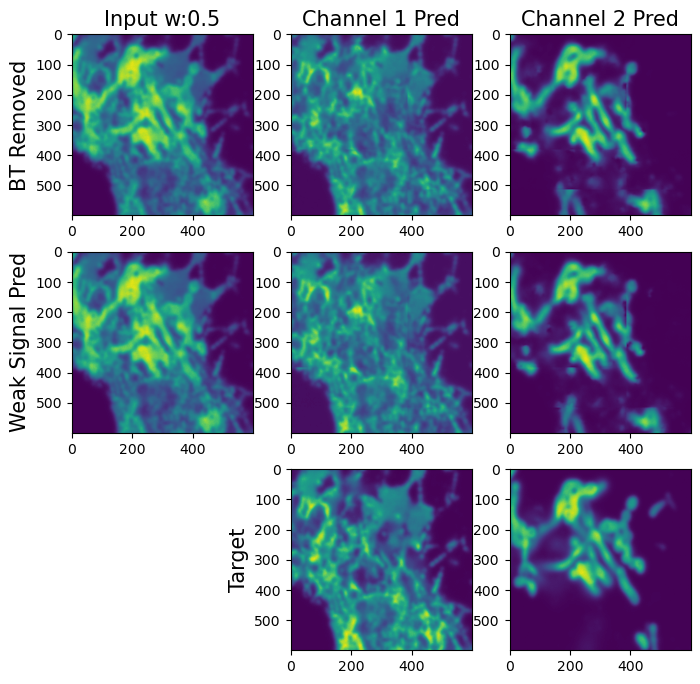

In [48]:
import matplotlib.pyplot as plt

_,ax = plt.subplots(figsize=(8,8),ncols=3,nrows=3)
img_idx = 0
hs = 0 
ws = 0
sz = 600
# inputs
ax[0,0].set_title(f'Input w:{mixing_t_ood}', fontsize=15)
ax[0,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,1])

#  ch1 predictions
ax[0,1].set_title('Channel 1 Pred', fontsize=15)
ax[0,1].imshow(pred_bt_removed_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,1].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])

# ch2 predictions
ax[0,2].set_title('Channel 2 Pred', fontsize=15)
ax[0,2].imshow(pred_bt_removed_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
ax[1,2].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,0].set_ylabel('BT Removed', fontsize=15)
ax[1,0].set_ylabel('Weak Signal Pred', fontsize=15)

# target
ax[2,0].axis('off')
ax[2,1].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[2,2].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
ax[2,1].set_ylabel('Target', fontsize=15)

In [102]:
# predicted t

# actual t
# T:1 W:0.5 M:1 PSNR: N1 Ch0: 33.8 +- 0.8	Ch1: 36.0 +- 0.8
# T:1 W:0.5 M:5 PSNR: N1 Ch0: 33.9 +- 0.8	Ch1: 36.0 +- 0.8

# T:2 W:0.5 M:1 PSNR: N2 Ch0: 33.0 +- 0.9	Ch1: 35.4 +- 0.7
# T:2 W:0.5 M:5 PSNR: N2 Ch0: 33.1 +- 0.9	Ch1: 35.5 +- 0.7

# T:5 W:0.5 M:1 PSNR: N5 Ch0: 32.2 +- 0.9	Ch1: 34.5 +- 0.7
# T:5 W:0.5 M:5 PSNR: N5 Ch0: 32.3 +- 0.9	Ch1: 34.6 +- 0.7



In [1]:
!ls -lhrt /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/jrc_hela-3/ | tail -n 10

-rw-r--r-- 1 ashesh.ashesh jug 359M Jan 12 22:37 jrc_hela-3_ch2_EGFP_Venus_R3.0_S4_D1_Ex100.0ms.tif
-rw-r--r-- 1 ashesh.ashesh jug  12M Feb  7 21:11 jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-9.0_S1_D4_Ex0.5ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 5.7M Feb  7 21:11 jrc_hela-3_ch1_EGFP_Venus_R3.0-9.0_S1_D4_Ex0.5ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 5.7M Feb  7 21:11 jrc_hela-3_ch2_EGFP_Venus_R3.0-9.0_S1_D4_Ex0.5ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 718M Feb  7 21:24 jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-9.0_S4_D1_Ex100.0ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 359M Feb  7 21:24 jrc_hela-3_ch1_EGFP_Venus_R3.0-9.0_S4_D1_Ex100.0ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 359M Feb  7 21:24 jrc_hela-3_ch2_EGFP_Venus_R3.0-9.0_S4_D1_Ex100.0ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 2.9G Feb  8 07:05 jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 1.5G Feb  8 07:05 jrc_hela-3_ch1_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif
-rw-r--r-- 1 ashesh.ashesh jug 1.5G Feb  8 07:0

In [2]:
from disentangle.core.tiff_reader import load_tiff
data = load_tiff('/group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/jrc_hela-3/jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif')

In [3]:
data.shape

(96, 2, 2800, 2800)

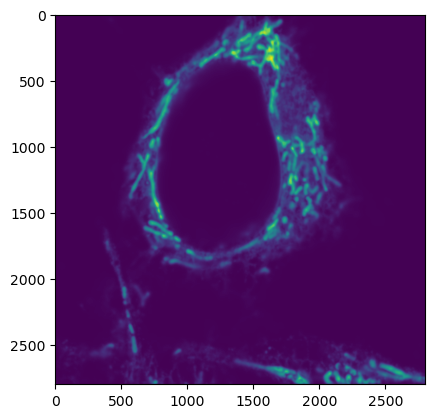

In [7]:
import matplotlib.pyplot as plt
plt.imshow(data[40,1])

In [1]:
import numpy as np

In [2]:
np.arange?

Docstring:
arange([start,] stop[, step,], dtype=None, *, like=None)

Return evenly spaced values within a given interval.

``arange`` can be called with a varying number of positional arguments:

* ``arange(stop)``: Values are generated within the half-open interval
  ``[0, stop)`` (in other words, the interval including `start` but
  excluding `stop`).
* ``arange(start, stop)``: Values are generated within the half-open
  interval ``[start, stop)``.
* ``arange(start, stop, step)`` Values are generated within the half-open
  interval ``[start, stop)``, with spacing between values given by
  ``step``.

For integer arguments the function is roughly equivalent to the Python
built-in :py:class:`range`, but returns an ndarray rather than a ``range``
instance.

When using a non-integer step, such as 0.1, it is often better to use
`numpy.linspace`.

See the Warning sections below for more information.

Parameters
----------
start : integer or real, optional
    Start of interval.  The interva

In [10]:
x = np.arange(start=0, stop=1000, step=1)
y = np.arange(start=0, stop=10000, step=10)
y = np.random.permutation(y)
int(np.quantile(x+y, 0.995)), int(np.quantile(x, 0.995) + np.quantile(y, 0.995))

(10671, 10934)

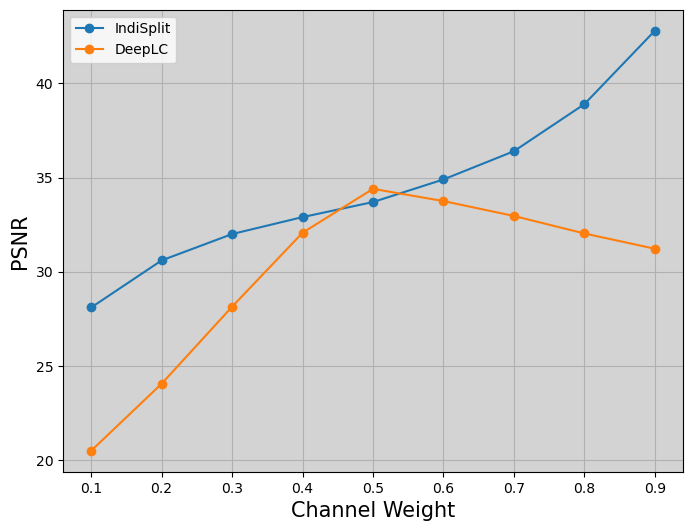

In [8]:
import matplotlib.pyplot as plt

w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
indisplit = [28.1, 30.6, 32.0, 32.9, 33.7,34.9,36.4, 38.9, 42.8 ]
deepLC = [20.49, 24.05, 28.14, 32.07, 34.4, 33.75, 32.96, 32.03, 31.22]
_,ax = plt.subplots(figsize=(8,6),)
ax.plot(w, indisplit, label='IndiSplit', marker='o')
ax.plot(w, deepLC, label='DeepLC', marker='o')
# add grid
ax.grid()
# background color
ax.set_facecolor('lightgrey')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xlabel('Channel Weight', fontsize=15)
ax.legend()